# Attention in Neural Networks
- The idea of attention is straightforward; choose a specific area of interest to "attend" when classifying
- Widely applied in neural machine translation, image captioning, speech recognition, etc.
- source code here is mostly derived from below 
    - https://github.com/philipperemy/keras-attention-mechanism
<br>
<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2016-11-08/060e380b28be29b7eda509981a50b4406ea6b21b/3-Figure2-1.png" style="width: 500px"/>

Attention can be regarded as "alignment" in machine translation context
</br>
    
    
<br>
<img src="https://cdn-images-1.medium.com/max/2000/1*ribYYJAU7EPdZtHFr0NDHw.png" style="width: 700px"/>

Visualizing attention in image captioning process
</br>

### Load Dataset
- Digits dataset in sklearn
- http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Input, concatenate, multiply, Dense, Permute, Reshape, LSTM, Activation
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
import keras.backend as K

from IPython.display import SVG

In [3]:
data = datasets.load_digits()

In [87]:
X_data = data.images
y_data = data.target

In [88]:
X_data = X_data.reshape(X_data.shape[0], 64)
y_data = to_categorical(y_data)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 777)

In [90]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1437, 64)
(360, 64)
(1437, 10)
(360, 10)


## Attention with MLP

In [91]:
def attention_mlp():
    input_layer = Input(shape = (X_train.shape[1],))
    attention_probs = Dense(X_train.shape[1], activation = 'softmax', name='attention_vec')(input_layer)    # attention vector is achieved here
    attention_mul = multiply([input_layer, attention_probs], name='attention_mul')
    
    attention_mul = Dense(50)(attention_mul)
    output_layer = Dense(10, activation = 'softmax')(attention_mul)
    
    model = Model(inputs = [input_layer], outputs = output_layer)
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

In [92]:
model = attention_mlp()

In [93]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 64)            0                                            
____________________________________________________________________________________________________
attention_vec (Dense)            (None, 64)            4160        input_5[0][0]                    
____________________________________________________________________________________________________
attention_mul (Multiply)         (None, 64)            0           input_5[0][0]                    
                                                                   attention_vec[0][0]              
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 50)            3250        attention_mul[0][0]     

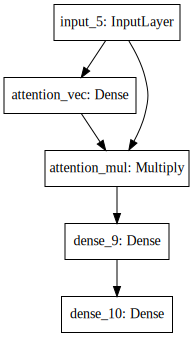

In [94]:
# In other words, attention mechanism can be explained as multiplying input nodes and softmax probabilities of each node elementwise
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [95]:
model.fit([X_train], y_train, epochs = 50, batch_size = 50, verbose = 0)

In [14]:
# function to obtain activation of each layer
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [49]:
attention_vector = get_activations(model,[X_train[0]], print_shape_only =True)[0]

----- activations -----
(1, 64)
(1, 64)
(1, 64)
(1, 50)
(1, 10)


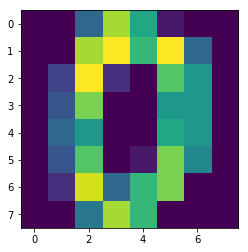

label:  0


In [50]:
plt.imshow(data.images[0])    # show first number in the dataset
plt.show()
print('label: ', data.target[0])    # label = '0'

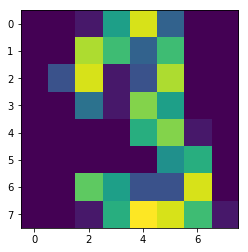

In [53]:
attention_vector = attention_vector.reshape(8,8)
plt.imshow(attention_vector)
plt.show()

In [24]:
X7 = []
for i in range(len(X_train)):
    if y_train[i][7] == 1:
        X7.append(X_train[i])
X7 = np.array(X7)

In [27]:
print(X7.shape)

(140, 64)


In [56]:
attention_vector = get_activations(model, X7, print_shape_only =True)[0]

----- activations -----
(140, 64)
(140, 64)
(140, 64)
(140, 50)
(140, 10)
(140, 64)


In [57]:
attention_vector = np.mean(attention_vector, axis = 0).reshape(8, 8)

(8, 8)

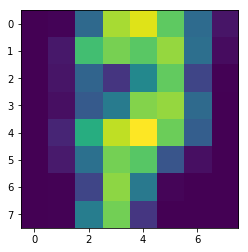

In [58]:
plt.imshow(attention_vector)
plt.show()

As expected, we could get a "vague" shape of "7" from our attention vector. This is where the model "attend to" when classifying the number 7.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

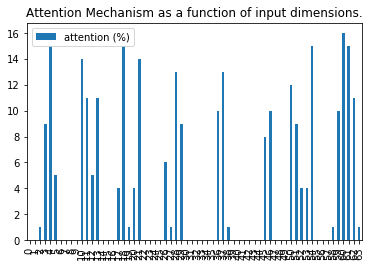

In [26]:
# visualizing activations in attention layer
pd.DataFrame(attention_vector.flatten(), columns=['attention (%)']).plot(kind='bar',title='Attention Mechanism as a function of input dimensions.')

## Attention with LSTM

<img src="https://github.com/philipperemy/keras-attention-mechanism/blob/master/assets/graph_multi_attention.png?raw=true" style="width: 400px"/>

In [60]:
# reshape data into original 3-D shape
X_data = X_data.reshape(X_data.shape[0], 8, 8)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 777)

In [62]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1437, 8, 8)
(360, 8, 8)
(1437, 10)
(360, 10)


In [63]:
INPUT_DIM = X_train.shape[2]
TIME_STEPS = X_train.shape[1]

# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False

In [64]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul')
    return output_attention_mul

In [65]:
def attention_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
    output = Dense(10, activation='softmax')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [72]:
model = attention_lstm()

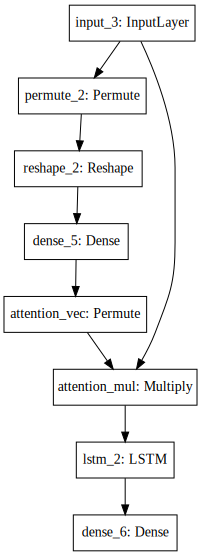

In [73]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [74]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 8, 8)          0                                            
____________________________________________________________________________________________________
permute_2 (Permute)              (None, 8, 8)          0           input_3[0][0]                    
____________________________________________________________________________________________________
reshape_2 (Reshape)              (None, 8, 8)          0           permute_2[0][0]                  
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 8, 8)          72          reshape_2[0][0]                  
___________________________________________________________________________________________

In [75]:
model.fit([X_train], y_train, epochs = 100, batch_size = 64, validation_split = 0.3, verbose = 0)

In [78]:
attention_vector = get_activations(model, [X_train[0]], print_shape_only=True, layer_name = 'attention_vec')[0].reshape(8,8)

----- activations -----
(1, 8, 8)


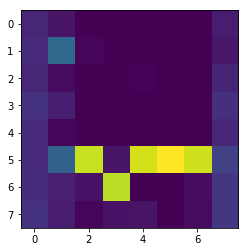

In [79]:
plt.imshow(attention_vector)
plt.show()